<img src="https://github.com/alan-barzilay/NLPortugues/blob/master/imagens/logo_nlportugues.png?raw=true"  style="height:65%" align="right">


# Lista 6 - LSTM&GRU 
**Nome: Felipe de Lima Peressim**

**Numero Usp: 11823558**









______________




O objetivo desta lista é fazer com que vocês treinem um modelo de análise de sentimentos utilizando GRU's e LSTM's. Essa lista é semelhante a lista 03 onde aprendemos a usar embeddings e onde você ja recebeu a arquitetura do seu modelo quase pronta. A diferença é que desta vez você ira construir sozinho sua rede e utilizará as camadas que acabamos de aprender: LSTM e GRU.
 
Essa tambêm será a primeira rede recorrente que montaremos, portanto a tokenização será ligeiramente diferente (por exemplo o padding não é mais necessário.)

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
tf.__version__

'2.2.0'

## Importando os dados como um dataframe

Para esta lista nós utilizaremos um recorte de 10 mil linhas do dataset **B2W-Reviews01** que consiste em avaliações de mais de 130k compras online no site Americanas.com e [esta disponivel no github](https://github.com/b2wdigital/b2w-reviews01) sob a licensa CC BY-NC-SA 4.01.

In [3]:
b2wCorpus = pd.read_csv("data/b2w-10k.csv")
b2wCorpus.head()

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958,F,RJ,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996,M,SC,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984,M,SP,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985,F,SP,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994,M,MG,NaN,NaN,NaN,NaN,NaN


In [4]:
b2wCorpus["review_text"]

0       Estou contente com a compra entrega rápida o ú...
1       Por apenas R$1994.20,eu consegui comprar esse ...
2       SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3       MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4       A entrega foi no prazo, as americanas estão de...
                              ...                        
9994    Celular muito rápido, com processador e armaze...
9995    achei o produto muito frágil, o material veio ...
9996    Uma porcaria pois ñ recebi ñ recomendo pra nin...
9997    Maquina excelente,super pratica. recomendo.ent...
9998    Agradeço pelo compromisso, obrigado. ,...........
Name: review_text, Length: 9999, dtype: object


## Pré-processamento 
# <font color='blue'>Questão 1 </font>
Copie suas etapas de préprocessamento da lista 03, ou seja, selecione apenas as colunas relevantes ("review_text" e "recommend_to_a_friend"), converta a coluna "review_text" de uma coluna de `str` para uma coluna de `int` e separe os dados em teste e treino.


In [5]:
to_drop = [column for column in b2wCorpus.columns if column != "review_text" and column != "recommend_to_a_friend"]
b2wCorpus.drop(to_drop, axis=1, inplace=True)
b2wCorpus.head()


,recommend_to_a_friend,review_text
0,Yes,Estou contente com a compra entrega rápida o ú...
1,Yes,"Por apenas R$1994.20,eu consegui comprar esse ..."
2,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4,Yes,"A entrega foi no prazo, as americanas estão de..."


In [6]:
b2wCorpus['recommend_to_a_friend'] = b2wCorpus['recommend_to_a_friend'].apply(lambda word : 1 if word.lower() == 'yes' else 0)
b2wCorpus.tail()

,recommend_to_a_friend,review_text
9994,1,"Celular muito rápido, com processador e armaze..."
9995,0,"achei o produto muito frágil, o material veio ..."
9996,0,Uma porcaria pois ñ recebi ñ recomendo pra nin...
9997,1,"Maquina excelente,super pratica. recomendo.ent..."
9998,1,"Agradeço pelo compromisso, obrigado. ,..........."


In [7]:
x = b2wCorpus['review_text'].values
y = b2wCorpus['recommend_to_a_friend'].values
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [8]:
print("Tamanho da menor sentença: ", len(min(x, key=len)))
print("Tamanho da maior sentença: ", len(max(x, key=len)))

Tamanho da menor sentença:  50
Tamanho da maior sentença:  1907


In [9]:
distribution_sentences_len = b2wCorpus['review_text'].apply(len).values
most_freq_sentence_length = np.bincount(distribution_sentences_len).argmax()
freq = len(b2wCorpus['review_text'][b2wCorpus['review_text'].apply(len) == most_freq_sentence_length])
print("Comprimento de sentença mais frequente no texto: ", most_freq_sentence_length)
print("Quantidade de vezes em que a sentença mais comum ocorre: ", freq)

Comprimento de sentença mais frequente no texto:  53
Quantidade de vezes em que a sentença mais comum ocorre:  176


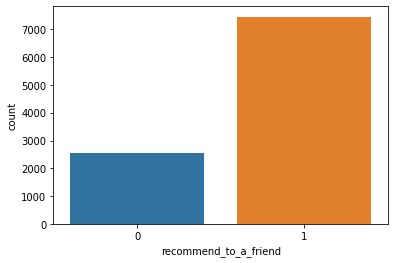

In [10]:
import seaborn as sns

sns.countplot(x='recommend_to_a_friend', data=b2wCorpus)

## Tokenizando




# <font color='blue'>Questão 2 </font>
Utilizando a camada [`TextVectorization`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization) tokenize os inputs.
Declare a camada e então chame a função `adapt()` no seu conjunto de treino para adequar o seu vocabulário aos reviews. 

Note que o uso de padding não é mais necessario.

In [11]:
textVecLayer = TextVectorization(output_mode="int", pad_to_max_tokens=False, output_sequence_length=100)                                                              
textVecLayer.adapt(x_train)
vocab_size = len(textVecLayer.get_vocabulary())
MAX_NB_WORDS = vocab_size
EMBEDDING_DIM = 128

/home/felipe/.local/lib/python3.6/site-packages/tensorflow/python/keras/layers/preprocessing/text_vectorization.py:338: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(preprocessed_data.to_list())


## LSTM&GRU

Agora vamos juntar a camada do tokenizador a nossa camada [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) e definir o resto de nosso modelo.

#  <font color='blue'>Questão 3 </font>

a) Defina, compile, treine e avalie seu modelo, utilize camadas  [LSTM](https://keras.io/api/layers/recurrent_layers/lstm/).
Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.
 
 
 
b) Como foi a performance desta rede em comparação a da lista 3?




**<font color='red'> Sua resposta aqui </font>**

A rede da lista 3 apresentou uma acurácia de 99,60% durante a fase de treinamento da rede, e uma acurácia de 86,06% no conjunto de testes. A rede LSTM aqui utilizada, obteve 88,00% de acurácia no conjunto de treino e 86,00% no conjunto de validação durante a fase de treinamento, e 85,00% de acurácia no conjunto de testes.

A rede LSTM exibiu uma performance muito melhor em realação a rede da lista 3, pois, a embora haja uma diferença de 2% entre a acurácia entre os conjuntos de treino e teste, isso não caracteriza um overtiffing, inclusive observando-se os gráficos plotados abaixo, pode-se constatar como as curvas de treino e validação que se encontram próximas uma da outra durante todas as épocas do treinamento. Em contrapartida, observou-se que ocorreu overfitting no modelo da lista 3 quando este exibiu uma diferença de 13% na acurácia entre os conjuntos de treino e teste. Portanto, o modelo LSTM se mostrou mais adequado para problema de processamento de linguagem natural em relação ao anterior utilizado na lista 3.

In [220]:
model = keras.Sequential()
model.add(textVecLayer)
model.add(keras.layers.Embedding(MAX_NB_WORDS + 2, EMBEDDING_DIM, input_length=100))
model.add(keras.layers.LSTM(64, dropout=0.5, return_sequences=True))
model.add(keras.layers.LSTM(64, dropout=0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 20
batch_size = 32

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/20
225/225 [==============================] - 30s 133ms/step - loss: 0.5675 - accuracy: 0.7469 - val_loss: 0.5515 - val_accuracy: 0.7588
Epoch 2/20
225/225 [==============================] - 30s 132ms/step - loss: 0.5257 - accuracy: 0.7559 - val_loss: 0.4485 - val_accuracy: 0.7600
Epoch 3/20
225/225 [==============================] - 29s 128ms/step - loss: 0.4085 - accuracy: 0.7732 - val_loss: 0.4322 - val_accuracy: 0.7575
Epoch 4/20
225/225 [==============================] - 30s 134ms/step - loss: 0.4172 - accuracy: 0.7565 - val_loss: 0.4238 - val_accuracy: 0.7663
Epoch 5/20
225/225 [==============================] - 31s 138ms/step - loss: 0.4289 - accuracy: 0.7472 - val_loss: 0.4435 - val_accuracy: 0.7500
Epoch 6/20
225/225 [==============================] - 29s 130ms/step - loss: 0.4376 - accuracy: 0.7323 - val_loss: 0.4576 - val_accuracy: 0.7500
Epoch 7/20
225/225 [==============================] - 31s 137ms/step - loss: 0.4528 - accuracy: 0.7368 - val_loss: 0.4495 - val_ac

In [224]:
model.evaluate(x_val, y_val)

63/63 [==============================] - 1s 23ms/step - loss: 0.4306 - accuracy: 0.8480


[0.43057456612586975, 0.8479999899864197]

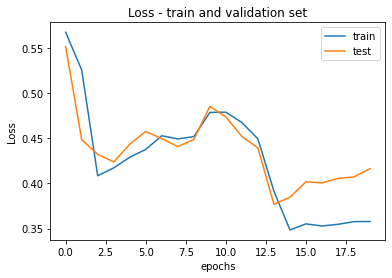

In [225]:
plt.title('Loss - train and validation set')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

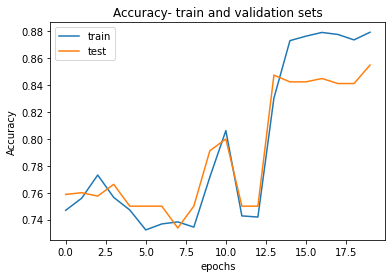

In [226]:
plt.title('Accuracy- train and validation sets')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

#  <font color='blue'>Questão 4 </font>

a) Defina, compile, treine e avalie seu modelo, utilize camadas [GRU](https://keras.io/api/layers/recurrent_layers/gru/).
Atenção a dimensão do input da camada de embedding, lembre se que < OOV > e < PAD > possuem seus próprios tokens.
 
 
 
b) Como foi a performance desta rede em comparação a da lista 3?


**<font color='red'> Sua resposta aqui </font>**

A rede GRU obteve um total de 99,62% de acurácia no conjunto de treinamento; no conjunto de validação um total de 85,50%; e no conjunto de testes 88.20% de acurácia. Embora este modelo apresente overfitting, a acurácia no conjunto de testes foi razoavelmente superior a rede da lista 3. No geral o modelo não exibe uma boa performance devido o overfitting, que conforme pode ser observado nos gráficos abaixo, o problema começa a partir da época 5, onde apenas ha melhora no desempenho em relação ao conjunto de treino, enquanto que no conjunto de validação a acurácia fica estagnada.

In [25]:
model = keras.Sequential()
model.add(textVecLayer)
model.add(keras.layers.Embedding(MAX_NB_WORDS + 2, EMBEDDING_DIM, input_length=100))
model.add(keras.layers.GRU(64, dropout=0.5, return_sequences=True))
model.add(keras.layers.GRU(64, dropout=0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs = 20
batch_size = 32

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/20
225/225 [==============================] - 35s 157ms/step - loss: 0.5671 - accuracy: 0.7479 - val_loss: 0.5879 - val_accuracy: 0.7200
Epoch 2/20
225/225 [==============================] - 32s 141ms/step - loss: 0.5636 - accuracy: 0.7508 - val_loss: 0.5864 - val_accuracy: 0.7250
Epoch 3/20
225/225 [==============================] - 32s 140ms/step - loss: 0.5581 - accuracy: 0.7565 - val_loss: 0.5932 - val_accuracy: 0.7287
Epoch 4/20
225/225 [==============================] - 30s 133ms/step - loss: 0.5525 - accuracy: 0.7589 - val_loss: 0.5878 - val_accuracy: 0.7300
Epoch 5/20
225/225 [==============================] - 27s 119ms/step - loss: 0.5515 - accuracy: 0.7595 - val_loss: 0.5944 - val_accuracy: 0.7312
Epoch 6/20
225/225 [==============================] - 29s 130ms/step - loss: 0.4338 - accuracy: 0.8155 - val_loss: 0.3112 - val_accuracy: 0.8650
Epoch 7/20
225/225 [==============================] - 28s 125ms/step - loss: 0.2107 - accuracy: 0.9218 - val_loss: 0.2892 - val_ac

In [26]:
model.evaluate(x_val, y_val)

63/63 [==============================] - 2s 25ms/step - loss: 0.6344 - accuracy: 0.8820


[0.6344143748283386, 0.8820000290870667]

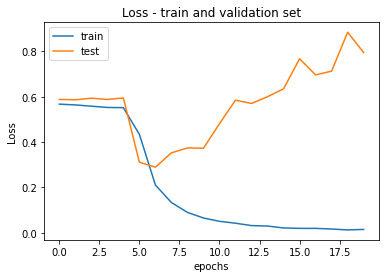

In [27]:
plt.title('Loss - train and validation set')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

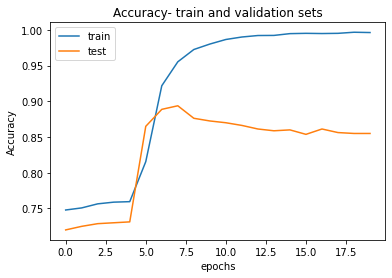

In [28]:
plt.title('Accuracy- train and validation sets')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## Redes Bi-direcionais
#  <font color='blue'>Questão 5 </font>

a) Defina, compile, treine e avalie um novo modelo que utilize contexto em ambas as direções usando a camada [`Bidirectional()`](https://keras.io/api/layers/recurrent_layers/bidirectional/), seja com camadas GRU ou LSTM.


b) Como foi sua performance em relação as questões anteriores com contexto unidirecional?

**<font color='red'> Sua resposta aqui </font>**

A performance a rede Bidirecional foi similar a rede GRU, ou seja, caracterizou overfitting ao exibir 99,59% de acurácia no conjunto de treinamento; 85,11% no conjunto de validação; e 85,27% no conjunto de testes. Assim, é necessário que algumas medidas sejam tomadas, como a obtenção de mais dados, experimentação com outras configurações no modelo, etc. Além disso, embora o modelo LSTM não tenha caracterizado overfitting, é de suma imporância realizar mais testes nos modelos, como por exemplo realizar um grid search para encontrar parâmetros ótimos e em seguida realizar um kfold para se obter uma acurácia média com desvio padrão. Assim, poder-se-á  refletir melhor aquilo que o os modelos na realidade representam.

A hipótese mais provavel para o overffiting observado nos modelos são devidos ao desbalanço que tem entre as classes que estamos prevendo, quanto a isso, diversas técnicas podem ser usadas para mitigar os efeitos de tal desproporcionalidade. Como combatê-los não era parte do objetivo aqui proposto, tais alternativas poder-se-ão ser utilizadas em exercícios futuros.

In [34]:
model = keras.Sequential()
model.add(textVecLayer)
model.add(keras.layers.Embedding(MAX_NB_WORDS + 2, EMBEDDING_DIM, input_length=100))
forward_layer = keras.layers.LSTM(64, return_sequences=True)
backward_layer = keras.layers.LSTM(64, return_sequences=True, go_backwards=True)
model.add(keras.layers.Bidirectional(forward_layer, backward_layer=backward_layer))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 20
batch_size = 32
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Epoch 1/20
225/225 [==============================] - 20s 89ms/step - loss: 0.4480 - accuracy: 0.8131 - val_loss: 0.3961 - val_accuracy: 0.8352
Epoch 2/20
225/225 [==============================] - 20s 87ms/step - loss: 0.3031 - accuracy: 0.8987 - val_loss: 0.4256 - val_accuracy: 0.8309
Epoch 3/20
225/225 [==============================] - 23s 100ms/step - loss: 0.2157 - accuracy: 0.9364 - val_loss: 0.3713 - val_accuracy: 0.8716
Epoch 4/20
225/225 [==============================] - 28s 125ms/step - loss: 0.1609 - accuracy: 0.9555 - val_loss: 0.3898 - val_accuracy: 0.8655
Epoch 5/20
225/225 [==============================] - 32s 142ms/step - loss: 0.1430 - accuracy: 0.9601 - val_loss: 0.3914 - val_accuracy: 0.8595
Epoch 6/20
225/225 [==============================] - 38s 170ms/step - loss: 0.1149 - accuracy: 0.9698 - val_loss: 0.3999 - val_accuracy: 0.8740
Epoch 7/20
225/225 [==============================] - 35s 156ms/step - loss: 0.1038 - accuracy: 0.9727 - val_loss: 0.5179 - val_accu

In [35]:
model.evaluate(x_val, y_val)

63/63 [==============================] - 1s 18ms/step - loss: 0.4978 - accuracy: 0.8527


[0.49777376651763916, 0.8527100086212158]

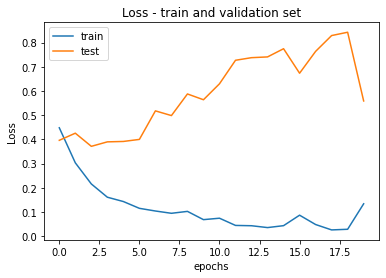

In [36]:
plt.title('Loss - train and validation set')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

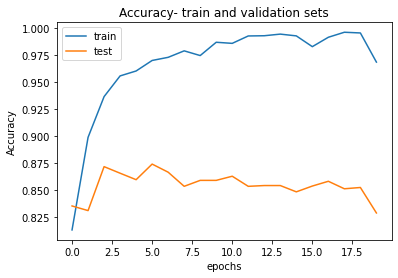

In [37]:
plt.title('Accuracy- train and validation sets')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();